In [1]:
!mkdir -p ~/.kaggle


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saiprasadb2","key":"bb3547730482026e83d19af87d5b372a"}'}

In [3]:
!cp kaggle.json ~/.kaggle/


In [4]:
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!ls ~/.kaggle


kaggle.json


In [6]:
!kaggle competitions download -c dogs-vs-cats


 98% 793M/812M [00:06<00:00, 192MB/s]
100% 812M/812M [00:06<00:00, 128MB/s]


In [7]:
!unzip -qq dogs-vs-cats.zip



In [8]:
!unzip -qq train.zip


In [9]:
!ls train


cat.0.jpg      cat.1966.jpg  cat.5180.jpg  cat.8396.jpg   dog.1160.jpg	 dog.3575.jpg  dog.6790.jpg
cat.10000.jpg  cat.1967.jpg  cat.5181.jpg  cat.8397.jpg   dog.11610.jpg  dog.3576.jpg  dog.6791.jpg
cat.10001.jpg  cat.1968.jpg  cat.5182.jpg  cat.8398.jpg   dog.11611.jpg  dog.3577.jpg  dog.6792.jpg
cat.10002.jpg  cat.1969.jpg  cat.5183.jpg  cat.8399.jpg   dog.11612.jpg  dog.3578.jpg  dog.6793.jpg
cat.10003.jpg  cat.196.jpg   cat.5184.jpg  cat.839.jpg	  dog.11613.jpg  dog.3579.jpg  dog.6794.jpg
cat.10004.jpg  cat.1970.jpg  cat.5185.jpg  cat.83.jpg	  dog.11614.jpg  dog.357.jpg   dog.6795.jpg
cat.10005.jpg  cat.1971.jpg  cat.5186.jpg  cat.8400.jpg   dog.11615.jpg  dog.3580.jpg  dog.6796.jpg
cat.10006.jpg  cat.1972.jpg  cat.5187.jpg  cat.8401.jpg   dog.11616.jpg  dog.3581.jpg  dog.6797.jpg
cat.10007.jpg  cat.1973.jpg  cat.5188.jpg  cat.8402.jpg   dog.11617.jpg  dog.3582.jpg  dog.6798.jpg
cat.10008.jpg  cat.1974.jpg  cat.5189.jpg  cat.8403.jpg   dog.11618.jpg  dog.3583.jpg  dog.6799.jpg
cat.

Question 1:

copying images to the test, validation, and training directories

In [10]:
import os, shutil, pathlib

original_dataset_dir = pathlib.Path("train")
base_dataset_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = base_dataset_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dataset_dir / fname,
                            dst=dir / fname)


make_subset("train", start_index=667, end_index=1667)
make_subset("validation", start_index=1668, end_index=2168)
make_subset("test", start_index=2169, end_index=2669)

Loading and processing images with 'image_dataset_from_directory

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train = image_dataset_from_directory(
    base_dataset_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation = image_dataset_from_directory(
    base_dataset_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test = image_dataset_from_directory(
    base_dataset_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Construct a dataset with 1000 instances, each having 16 random values.

In [12]:
import numpy as np
import tensorflow as tf
random_num = np.random.normal(size=(1000, 16))
data = tf.data.Dataset.from_tensor_slices(random_num)

In [13]:
for i, element in enumerate(data):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [14]:
for i, element in enumerate(data):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [15]:
reshapedata = data.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshapedata):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


Building a small neural network to differentiate dog and cat images

In [16]:
for data_batch, labels_batch in train:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [17]:
from tensorflow import keras
from tensorflow.keras import layers

input = keras.Input(shape=(180, 180, 3))
l = layers.Rescaling(1./255)(input)
l = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(l)
l = layers.MaxPooling2D(pool_size=2)(l)
l = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(l)
l = layers.MaxPooling2D(pool_size=2)(l)
l = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(l)
l = layers.MaxPooling2D(pool_size=2)(l)
l = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(l)
l = layers.MaxPooling2D(pool_size=2)(l)
l = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(l)
l = layers.Flatten()(l)
l = layers.Dropout(0.5)(l)
output1 = layers.Dense(1, activation="sigmoid")(l)
model1 = keras.Model(inputs=input, outputs=output1)

preparing model for training

In [18]:
model1.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

The model is initially developed, followed by training on the training set. To evaluate the model's performance at each stage, we utilize the validation set.

In [19]:
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

The dataset is used to refine the model's parameters.


In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callback1 = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history1 = model1.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=callback1)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.4915 - loss: 0.6944 - val_accuracy: 0.5980 - val_loss: 0.6924
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.4914 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.5059 - loss: 0.6933 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.5010 - loss: 0.6935 - val_accuracy: 0.5500 - val_loss: 0.6752
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.4879 - loss: 0.6919 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.4945 - loss: 0.6933 - val_accuracy: 0.5380 - val_loss: 0.6931
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.5104 - loss: 0.6932 - val_accuracy: 0.5170 - val_loss: 0.6931
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.5013 - loss: 0.6932 - val_accuracy: 0.4900 -

To visualize the model's performance over time, training curves for accuracy and loss were created.


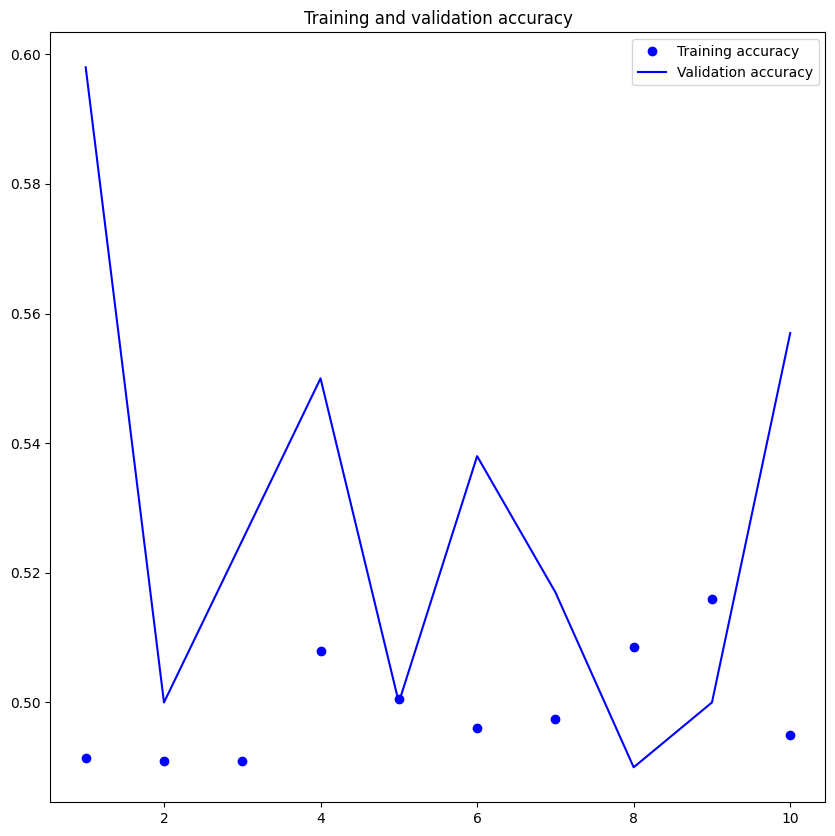

<Figure size 640x480 with 0 Axes>

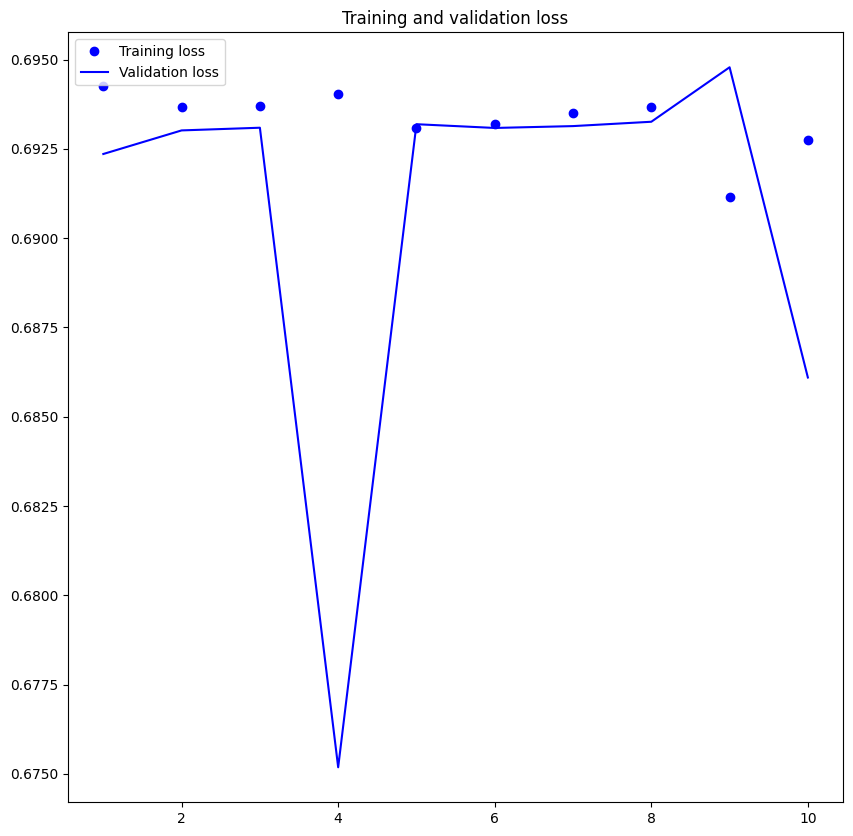

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
accuracy1 = history1.history["accuracy"]
val_accuracy1 = history1.history["val_accuracy"]
loss1 = history1.history["loss"]
val_loss1 = history1.history["val_loss"]
epochs = range(1, len(accuracy1) + 1)
plt.plot(epochs, accuracy1, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy1, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss1, "bo", label="Training loss")
plt.plot(epochs, val_loss1, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [22]:
testacc1 = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = testacc1.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5435 - loss: 0.6760
Test accuracy: 0.550


According to the above result, the test accuracy without data augmentation is about 69.3%, while the training accuracy is about 92%.


Question 2:

Expanding image dataset: Adding data augmentation to an image model.

In [23]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

# Defining the original directory and the new base directory
original_dataset_dir = pathlib.Path("train")
base_dataset_dir = pathlib.Path("cats_vs_dogs_small_Q2")

# Functions to create subsets
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = base_dataset_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)  # Create directory, if it doesn't exist
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dataset_dir / fname,
                            dst=dir / fname)

# Creating subsets for training, validation, and testing
make_subset("train", start_index=667, end_index=2167)  # 1500 samples
make_subset("validation", start_index=2168, end_index=2668)  # 500 samples
make_subset("test", start_index=2669, end_index=3168)  # 500 samples


In [24]:
augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

showing the training augmented pictures

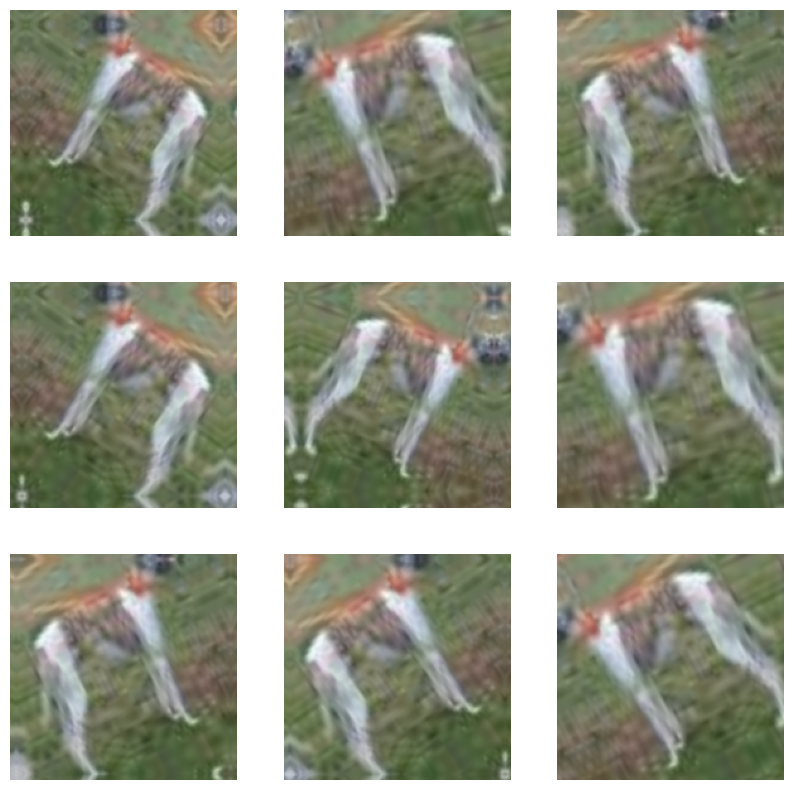

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train.take(1):
    for i in range(9):
        augmented_pics = augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_pics[0].numpy().astype("uint8"))
        plt.axis("off")

Developing a new convolutional neural network that includes picture augmentation and dropout


In [26]:
input2 = keras.Input(shape=(180, 180, 3))
m = augmentation(input2)
m = layers.Rescaling(1./255)(m)
m = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(m)
m = layers.MaxPooling2D(pool_size=2)(m)
m = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(m)
m = layers.MaxPooling2D(pool_size=2)(m)
m = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(m)
m = layers.MaxPooling2D(pool_size=2)(m)
m = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(m)
m = layers.MaxPooling2D(pool_size=2)(m)
m = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(m)
m = layers.Flatten()(m)
m = layers.Dropout(0.5)(m)
output2 = layers.Dense(1, activation="sigmoid")(m)
model2 = keras.Model(inputs=input2, outputs=output2)

model2.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
callback2 = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history2 = model2.fit(
    train,
    epochs=30,
    validation_data=validation,
    callbacks=callback2)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.5085 - loss: 0.6950 - val_accuracy: 0.5630 - val_loss: 0.6919
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5116 - loss: 0.6928 - val_accuracy: 0.5010 - val_loss: 0.6927
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.5202 - loss: 0.6901 - val_accuracy: 0.5750 - val_loss: 0.6711
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.5567 - loss: 0.6824 - val_accuracy: 0.5910 - val_loss: 0.6740
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.5559 - loss: 0.6854 - val_accuracy: 0.5880 - val_loss: 0.6694
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.5714 - loss: 0.6829 - val_accuracy: 0.6270 - val_loss: 0.6624
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.5831 - loss: 0.6671 - val_accuracy: 0.6160 - val_loss: 0.6623
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.5945 - loss: 0.6635 - val_accuracy: 0.6290

Model evaluated based on test set

In [28]:
testacc2 = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = testacc2.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7389 - loss: 0.4971
Test accuracy: 0.756


Question 3:

In the third step, training sets of 2000 samples were employed, with 500 samples reserved for validation and testing. I discovered that the test accuracy was superior with 1500 training samples compared to 1000 or 2000. Moreover, training accuracy improved with 1000 training samples. Increasing the training set to 2000 while maintaining the same validation and testing sets resulted in these findings.

In [29]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=667, end_index=2667)
make_subset("validation", start_index=2668, end_index=3168)
make_subset("test", start_index=3169, end_index=3669)

Click enter to edit the data

In [30]:
i3 = keras.Input(shape=(180, 180, 3))
n = augmentation(i3)
n = layers.Rescaling(1./255)(n)
n = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(n)
n = layers.MaxPooling2D(pool_size=2)(n)
n = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(n)
n = layers.MaxPooling2D(pool_size=2)(n)
n = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(n)
n = layers.MaxPooling2D(pool_size=2)(n)
n = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(n)
n = layers.MaxPooling2D(pool_size=2)(n)
n = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(n)
n = layers.Flatten()(n)
n = layers.Dropout(0.5)(n)
out3 = layers.Dense(1, activation="sigmoid")(n)
mod3 = keras.Model(inputs=i3, outputs=out3)

mod3.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [31]:
callback3 = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
hist3 = mod3.fit(
    train,
    epochs=50,
    validation_data=validation,
    callbacks=callback3)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.5181 - loss: 0.6971 - val_accuracy: 0.5220 - val_loss: 0.6928
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5181 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.4912 - loss: 0.6936 - val_accuracy: 0.5300 - val_loss: 0.6906
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5004 - loss: 0.6941 - val_accuracy: 0.5480 - val_loss: 0.6866
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5395 - loss: 0.6915 - val_accuracy: 0.5220 - val_loss: 0.6869
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.5133 - loss: 0.6941 - val_accuracy: 0.5240 - val_loss: 0.6881
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5479 - loss: 0.6876 - val_accuracy: 0.5060 - val_loss: 0.6874
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.4961 - loss: 0.6916 - val_accuracy: 0.5170 - v

In [32]:
acc_test3 = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = acc_test3.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8008 - loss: 0.4771
Test accuracy: 0.801


Question 4:


Creating the VGG16 convolutional base

In [33]:
convolution_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
convolution_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Utilizing a pre-trained model for feature extraction without data augmentation: Obtaining the labels associated with the VGG16 characteristics

In [35]:
import numpy as np

def get_features_and_labels(dataset):
    all_feature = []
    all_label = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = convolution_base.predict(preprocessed_images)
        all_feature.append(features)
        all_label.append(labels)
    return np.concatenate(all_feature), np.concatenate(all_label)

train_features, train_labels =  get_features_and_labels(train)
val_features, val_labels =  get_features_and_labels(validation)
test_features, test_labels =  get_features_and_labels(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [36]:
train_features.shape

(2000, 5, 5, 512)

In [37]:
i6 = keras.Input(shape=(5, 5, 512))
p = layers.Flatten()(i6)
p = layers.Dense(256)(p)
p = layers.Dropout(0.5)(p)
out6 = layers.Dense(1, activation="sigmoid")(p)
m6 = keras.Model(i6, out6)
m6.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callback6 = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
hist6 = m6.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callback6)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8724 - loss: 31.2729 - val_accuracy: 0.9670 - val_loss: 4.0264
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9818 - loss: 2.0303 - val_accuracy: 0.9530 - val_loss: 7.5124
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9795 - loss: 2.2678 - val_accuracy: 0.9760 - val_loss: 3.8838
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9943 - loss: 0.5179 - val_accuracy: 0.9790 - val_loss: 3.8262
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9889 - loss: 1.0557 - val_accuracy: 0.9760 - val_loss: 4.1983
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9961 - loss: 0.9731 - val_accuracy: 0.9770 - val_loss: 4.5276
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.2155 - val_accuracy: 0.9760 - val_loss: 4.1559
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.1086 - val_accuracy: 0.9780 - val_lo

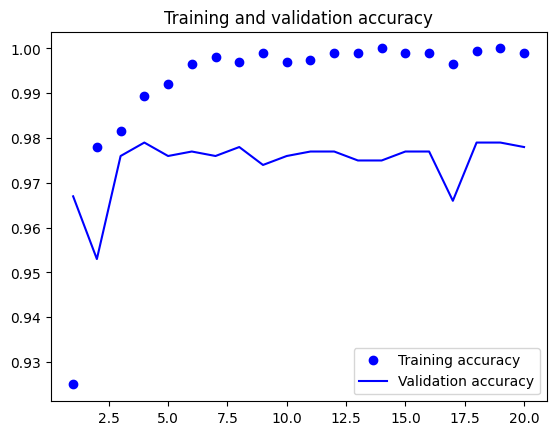

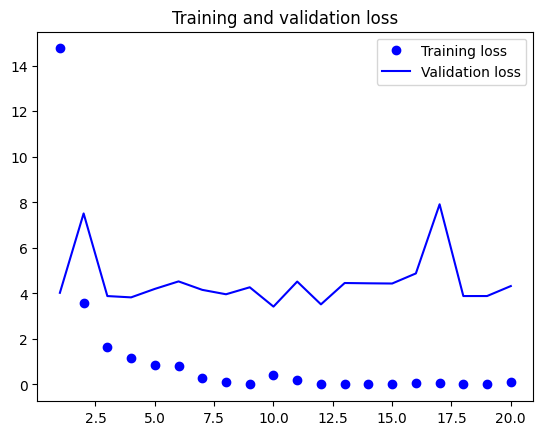

In [38]:
import matplotlib.pyplot as plt
accuracy6 = hist6.history["accuracy"]
valaccuracy6 = hist6.history["val_accuracy"]
los6 = hist6.history["loss"]
vallos6 = hist6.history["val_loss"]
epochs = range(1, len(accuracy6) + 1)
plt.plot(epochs, accuracy6, "bo", label="Training accuracy")
plt.plot(epochs, valaccuracy6, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, los6, "bo", label="Training loss")
plt.plot(epochs, vallos6, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


VGG16 convolutional base instantiation and freezing

In [39]:
convolution_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
convolution_base.trainable = False

convolution_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(convolution_base.trainable_weights))

convolution_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(convolution_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


Model is now performing with a classifier and agumentation to convulation base

In [40]:
augmentation2 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

input22 = keras.Input(shape=(180, 180, 3))
x1 = augmentation2(input22)
x1 =keras.layers.Lambda(
     lambda x: keras.applications.vgg16.preprocess_input(x))(x1)
x1 = convolution_base(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dense(256)(x1)
x1 = layers.Dropout(0.5)(x1)
outputs = layers.Dense(1, activation="sigmoid")(x1)
model = keras.Model(input22, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [41]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="features_extraction_with_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=callbacks
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - accuracy: 0.8176 - loss: 60.2750 - val_accuracy: 0.9690 - val_loss: 3.5858
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 0.9393 - loss: 6.5125 - val_accuracy: 0.9740 - val_loss: 3.5947
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9542 - loss: 6.3552 - val_accuracy: 0.9740 - val_loss: 4.0053
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9557 - loss: 5.5402 - val_accuracy: 0.9730 - val_loss: 4.6457
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.9677 - loss: 3.8822 - val_accuracy: 0.9760 - val_loss: 3.0390
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.9647 - loss: 4.4639 - val_accuracy: 0.9790 - val_loss: 2.5555
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 199ms/step - accuracy: 0.9642 - loss: 3.9545 - val_accuracy: 0.9750 - val_loss: 3.8935
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.9803 - loss: 2.6105 - val_acc

In [42]:
!ls -lh features_extraction_with_augmentation2.keras


-rw-r--r-- 1 root root 82M Oct 21 01:54 features_extraction_with_augmentation2.keras


In [43]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16

# Define the model
augmentation2 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

input22 = keras.Input(shape=(180, 180, 3))

a1 = augmentation2(input22)

# Specify output_shape for Lambda layer
a1 = keras.layers.Lambda(
    lambda x: vgg16.preprocess_input(x),
    output_shape=(180, 180, 3)
)(a1)

a1 = convolution_base(a1)
a1 = layers.Flatten()(a1)
a1 = layers.Dense(256)(a1)
a1 = layers.Dropout(0.5)(a1)
outputs = layers.Dense(1, activation="sigmoid")(a1)

model = keras.Model(input22, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Save the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="features_extraction_with_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=callbacks
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 0.8370 - loss: 31.4731 - val_accuracy: 0.9730 - val_loss: 3.0640
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.9394 - loss: 7.7954 - val_accuracy: 0.9750 - val_loss: 4.5554
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - accuracy: 0.9619 - loss: 4.6397 - val_accuracy: 0.9690 - val_loss: 6.4034
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - accuracy: 0.9655 - loss: 4.3810 - val_accuracy: 0.9820 - val_loss: 2.8130
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.9648 - loss: 4.3565 - val_accuracy: 0.9830 - val_loss: 3.9193
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.9696 - loss: 3.2514 - val_accuracy: 0.9810 - val_loss: 3.4288
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.9752 - loss: 4.1358 - val_accuracy: 0.9800 - val_loss: 3.8578
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9687 - loss: 2.8502 - val_acc

Fine-tuning a pretrained model

Freezing all layers until the fourth from the last

In [44]:
convolution_base.trainable = True
for layer in convolution_base.layers[:-4]:
    layer.trainable = False

In [45]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbackstu = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
historytune = model.fit(
    train,
    epochs=30,
    validation_data=validation,
    callbacks=callbackstu)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.9799 - loss: 1.6087 - val_accuracy: 0.9850 - val_loss: 2.2577
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.9864 - loss: 0.9137 - val_accuracy: 0.9810 - val_loss: 2.6282
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 220ms/step - accuracy: 0.9788 - loss: 1.3883 - val_accuracy: 0.9810 - val_loss: 2.2709
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.9858 - loss: 0.7930 - val_accuracy: 0.9810 - val_loss: 2.6874
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.9851 - loss: 0.3979 - val_accuracy: 0.9810 - val_loss: 2.1853
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.9904 - loss: 0.3508 - val_accuracy: 0.9830 - val_loss: 1.9964
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 233ms/step - accuracy: 0.9930 - loss: 0.2193 - val_accuracy: 0.9850 - val_loss: 1.8092
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - accuracy: 0.9894 - loss: 0.4452 - val_accu

In [46]:
model_tuning = keras.models.load_model("fine_tuning.keras",safe_mode=False)
test_loss, test_acc = model.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9713 - loss: 2.2128
Test accuracy: 0.969
